Based on [this DiCE example notebook](https://github.com/interpretml/DiCE/blob/78ca5391467ba12e38730e71577fbe421d9f0ba2/docs/source/notebooks/DiCE_with_advanced_options.ipynb).

In [1]:
# import DiCE
import dice_ml
from dice_ml.utils import helpers # helper functions

# Tensorflow libraries
import tensorflow as tf
from tensorflow import keras

In [2]:
dataset = helpers.load_adult_income_dataset()

In [3]:
dataset.head()

,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,39,Government,Bachelors,Single,White-Collar,White,Male,40,0
1,50,Self-Employed,Bachelors,Married,White-Collar,White,Male,13,0
2,38,Private,HS-grad,Divorced,Blue-Collar,White,Male,40,0
3,53,Private,School,Married,Blue-Collar,Other,Male,40,0
4,28,Private,Bachelors,Married,Professional,Other,Female,40,0


In [4]:
d = dice_ml.Data(dataframe=dataset, continuous_features=['age', 'hours_per_week'], outcome_name='income')

In [5]:
# seeding random numbers for reproducability
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

In [6]:
train, _ = d.split_data(d.normalize_data(d.one_hot_encoded_data))
X_train = train.loc[:, train.columns != 'income']
y_train = train.loc[:, train.columns == 'income']

ann_model = keras.Sequential()
ann_model.add(keras.layers.Dense(20, input_shape=(X_train.shape[1],), kernel_regularizer=keras.regularizers.l1(0.001), activation=tf.nn.relu))
ann_model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

ann_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01), metrics=['accuracy'])
ann_model.fit(X_train, y_train, validation_split=0.20, epochs=100, verbose=0, class_weight={0:1,1:2})
# the training will take some time for 100 epochs.
# you can wait or set verbose=1 to see the progress of training.

In [ ]:
backend = 'TF'+tf.__version__[0] # TF2
m = dice_ml.Model(model=ann_model, backend=backend)

In [ ]:
# query instance in the form of a dictionary; keys: feature name, values: feature value
query_instance = {'age':22, 
                  'workclass':'Private', 
                  'education':'HS-grad', 
                  'marital_status':'Single', 
                  'occupation':'Service',
                  'race': 'White', 
                  'gender':'Female', 
                  'hours_per_week': 45}

In [ ]:
exp = dice_ml.Dice(d, m)
dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=4, desired_class="opposite")

In [29]:
dice_exp.visualize_as_dataframe()#(show_only_changes=True)

Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,22.0,Private,HS-grad,Single,Service,White,Female,45.0,0.009411



Diverse Counterfactual set (new outcome : 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,57.0,Private,Doctorate,Single,White-Collar,White,Female,45.0,0.724
1,36.0,Private,Prof-school,Married,Service,White,Female,37.0,0.869
2,22.0,Self-Employed,Doctorate,Married,Service,White,Female,45.0,0.755
3,43.0,Private,HS-grad,Married,White-Collar,White,Female,63.0,0.822


# Parallel Coordinates Plot

In [4]:
import pandas as pd

data1=[[22.0,'Private','HS-grad','Single','Service','White','Female',45.0,0.009411],
       [57.0,'Private','Doctorate','Single','White-Collar','White','Female',45.0,0.724],
       [36.0,	'Private',	'Prof-school',	'Married',	'Service',	'White','Female',	37.0,	0.869],
       [22.0,	'Self-Employed',	'Doctorate',	'Married',	'Service',	'White',	'Female',	45.0,	0.755],
       [43.0,	'Private',	'HS-grad',	'Married',	'White-Collar',	'White',	'Female',	63.0,	0.822]]

columns1=['age', 'workclass','education','marital_status','occupation','race','gender','hours_per_week','income'] 
  
df = pd.DataFrame(data1, columns = columns1)


In [5]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

df['workclass'] =labelencoder.fit_transform(df['workclass'])
df['education'] =labelencoder.fit_transform(df['education'])
df['marital_status'] =labelencoder.fit_transform(df['marital_status'])
df['occupation'] =labelencoder.fit_transform(df['occupation'])
df['race'] =labelencoder.fit_transform(df['race'])
df['gender'] =labelencoder.fit_transform(df['gender'])

df

,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,22.0,0,1,1,0,0,0,45.0,0.009411
1,57.0,0,0,1,1,0,0,45.0,0.724000
2,36.0,0,2,0,0,0,0,37.0,0.869000
3,22.0,1,0,0,0,0,0,45.0,0.755000
4,43.0,0,1,0,1,0,0,63.0,0.822000


In [6]:
target_values=[0,1,1,1,1]

/Users/ninapiesanen/VIDA/counterfactual_explorer/env/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  # Remove the CWD from sys.path while we load stuff.


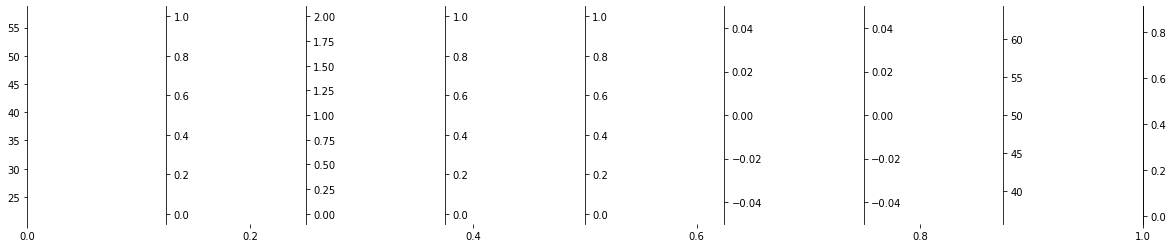

In [19]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy as np

fig, host = plt.subplots(figsize=(20,4))

axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

/Users/ninapiesanen/VIDA/counterfactual_explorer/env/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/Users/ninapiesanen/VIDA/counterfactual_explorer/env/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
/Users/ninapiesanen/VIDA/counterfactual_explorer/env/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Legend does not support None instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


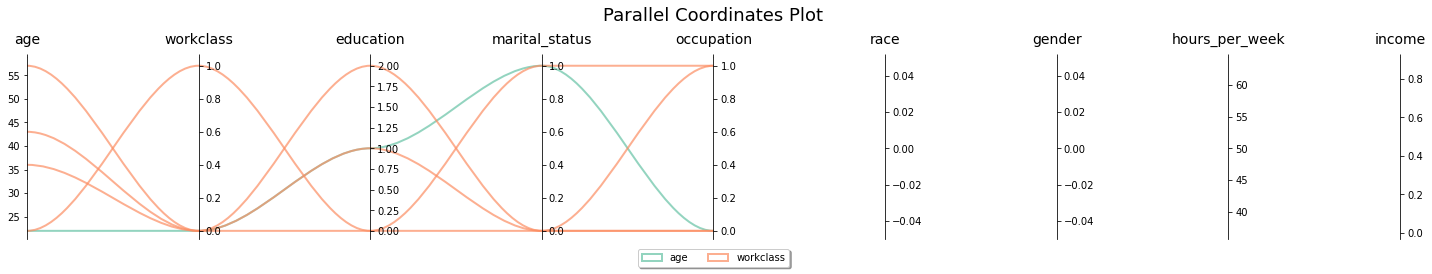

In [14]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy as np
from sklearn import datasets

ynames = columns1
ys = df.values
ymins = ys.min(axis=0)
ymaxs = ys.max(axis=0)
dys = ymaxs - ymins
ymins -= dys * 0.05  # add 5% padding below and above
ymaxs += dys * 0.05

# transform all data to be compatible with the main axis
zs = np.zeros_like(ys)
zs[:, 0] = ys[:, 0]
zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

fig, host = plt.subplots(figsize=(20,4))

axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

host.set_xlim(0, ys.shape[1] - 1)
host.set_xticks(range(ys.shape[1]))
host.set_xticklabels(ynames, fontsize=14)
host.tick_params(axis='x', which='major', pad=7)
host.spines['right'].set_visible(False)
host.xaxis.tick_top()
host.set_title('Parallel Coordinates Plot', fontsize=18, pad=12)

colors = plt.cm.Set2.colors
legend_handles = [None for _ in columns1]
for j in range(ys.shape[0]):
    # create bezier curves
    verts = list(zip([x for x in np.linspace(0, len(ys) - 1, len(ys) * 3 - 2, endpoint=True)],
                     np.repeat(zs[j, :], 3)[1:-1]))
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=2, alpha=0.7, edgecolor=colors[target_values[j]])
    legend_handles[target_values[j]] = patch
    host.add_patch(patch)
host.legend(legend_handles, columns1,
            loc='lower center', bbox_to_anchor=(0.5, -0.18),
            ncol=len(columns1), fancybox=True, shadow=True)
plt.tight_layout()
plt.show()

# Widget

In [101]:
#inputs

output_var=['income']
cont_feat=['age','hours_per_week']

In [147]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display, clear_output
from ipywidgets import Checkbox, VBox,HBox


column_names=[]
for i in list(dataset.columns):
    column_names.append(i)


feature_names=[]
for i in column_names:
    if i!=output_var[0]:
        feature_names.append(i)
print(feature_names)

['age', 'workclass', 'education', 'marital_status', 'occupation', 'race', 'gender', 'hours_per_week']


In [146]:
feature_children=[]
for i in feature_names:
    new_check1=Checkbox(description=i, value=True)
    feature_children.append(new_check1)

feature_vb = VBox(children = feature_children)
use_all_feat = Checkbox(description='Use all features? ',value=True)

extra_checks=[]
def add_checks(button):
    if button['old']:
        print('Deselect features you do not want to vary')
        feature_vb.children = feature_children
        display(feature_vb)
        extra_checks.append(feature_children)
    else:
        feature_vb.children=[]


use_all_feat.observe(add_checks, names='value')
display(use_all_feat)

Checkbox(value=True, description='Use all features? ')

In [138]:
feature_values=[]

for i in range(len(extra_checks[0])):
    feature_values.append(extra_checks[0][i].value)

features_touse=[]
for i in range(len(feature_values)):
    if feature_values[i] is True:
        features_touse.append(feature_names[i])

print(features_touse)

['age', 'workclass', 'education', 'marital_status', 'occupation', 'race', 'gender', 'hours_per_week']


In [132]:
from ipywidgets import Checkbox, VBox

feat_child=[]
for i in features_touse:
    new_slider=widgets.FloatSlider(description=i, value=1, max=5)
    feat_child.append(new_slider)

vb = VBox(children = feat_child)
top_toggle1 = Checkbox(description='Assign Feature Weights?')

def add_sliders(button):
    if button['new']:
        vb.children = feat_child
        display(vb)
    else:
        vb.children=[]
    
top_toggle1.observe(add_sliders, names='value')
display(top_toggle1)

Checkbox(value=False, description='Assign Feature Weights?')

In [133]:
from ipywidgets import interactive
from IPython.display import display
from ipywidgets import Checkbox, VBox

prox = widgets.FloatSlider(description='Proximity Weight', max=10, value=0.5)
div = widgets.FloatSlider(description='Diversity Weight', max=10, value=1)
#proximity_weight (default: 0.5) and diversity_weight (default: 1.0)


vb3 = VBox(children = [prox, div])
top_toggle2 = Checkbox(description='Tune proximity/diversity?')

def add_2(button):
    if button['new']:
        vb3.children = [prox, div]
        display(vb3)
    else:
        vb3.children=[]

top_toggle2.observe(add_2, names='value')
display(top_toggle2)

Checkbox(value=False, description='Tune proximity/diversity?')

In [131]:
highlight_changes=widgets.Checkbox(
    #value=False,
    description='Only highlight changes in explanations',
    disabled=False,
    indent=False
)

num_exp = widgets.IntSlider(description='Number of Explanations', min=1, max=5)
         

In [151]:
from ipywidgets import TwoByTwoLayout


TwoByTwoLayout(top_left=highlight_changes,
               top_right=num_exp,
               bottom_left=top_toggle1,
               bottom_right=top_toggle2)

TwoByTwoLayout(children=(Checkbox(value=False, description='Only highlight changes in explanations', indent=Fa…

In [112]:

inputq=[]
print('Input Query:')

index=-1
for i in features_touse:
    index+=1
    if i in cont_feat:
        cont_text=widgets.Text(value='', description=i)
        display(cont_text)
        inputq.append(cont_text)
        
    else:
        noncont_dropdown=widgets.Dropdown(description=i,options=dataset[i].unique())
        display(noncont_dropdown)
        inputq.append(noncont_dropdown)
        
        
        
        
#query_instance = {'age':22, 
 #                 'workclass':'Private', 
  #                'education':'HS-grad', 
   #               'marital_status':'Single', 
    #              'occupation':'Service',
     #             'race': 'White', 
      #            'gender':'Female', 
       #           'hours_per_week': 45}

Input Query:


Text(value='', description='age')

Dropdown(description='workclass', options=('Government', 'Self-Employed', 'Private', 'Other/Unknown'), value='…

Dropdown(description='education', options=('Bachelors', 'HS-grad', 'School', 'Masters', 'Some-college', 'Assoc…

Dropdown(description='marital_status', options=('Single', 'Married', 'Divorced', 'Separated', 'Widowed'), valu…

Dropdown(description='occupation', options=('White-Collar', 'Blue-Collar', 'Professional', 'Service', 'Sales',…

Dropdown(description='race', options=('White', 'Other'), value='White')

Dropdown(description='gender', options=('Male', 'Female'), value='Male')

Text(value='', description='hours_per_week')

# Generating Counterfactuals

In [69]:
#MAKING THE DATASET
def make_d(data):
    d = dice_ml.Data(dataframe=data, continuous_features=continous_features, outcome_name=dropdown.value)

make_d(dataset)

In [70]:
#MAKING THE MODEL

def make_m(modelname):
    model=[]
    backend = 'TF'+tf.__version__[0] # TF2
    m = dice_ml.Model(model=modelname, backend=backend)
    model.append(m)

make_m(ann_model)

In [71]:
#making query values that are supposed to be integers into integers

cont_feat_selected=[]
for i in feature_names:
    if i in continous_features:
        cont_feat_selected.append(1)
    else:
        cont_feat_selected.append(0)
        
print(cont_feat_selected)


#creating query_instance from widget output by zipping feature names and inputted query values together
query_values=[]

for i in range(len(inputq)):
    if cont_feat_selected[i]==1:
        query_values.append(int(inputq[i].value))
    elif cont_feat_selected[i]==0:
        query_values.append(inputq[i].value)
    
query_instance = dict(zip(feature_names, query_values))

print(query_instance)

[1, 0, 0, 0, 0, 0, 0, 1]
{'age': 22, 'workclass': 'Private', 'education': 'HS-grad', 'marital_status': 'Single', 'occupation': 'Service', 'race': 'White', 'gender': 'Female', 'hours_per_week': 45}


In [72]:
exp = dice_ml.Dice(d, model[0])
dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=num_exp.value, desired_class="opposite",
                                        proximity_weight=prox.value, diversity_weight=div.value)
    
if new_widg.value is True:
    dice_exp.visualize_as_dataframe(show_only_changes=True)
else:
    dice_exp.visualize_as_dataframe()

Diverse Counterfactuals found! total time taken: 00 min 49 sec
Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,22.0,Private,HS-grad,Single,Service,White,Female,45.0,0.009411



Diverse Counterfactual set (new outcome : 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,57.0,-,Doctorate,-,White-Collar,-,-,-,0.724
1,36.0,-,Prof-school,Married,-,-,-,37.0,0.869
2,-,Self-Employed,Doctorate,Married,-,-,-,-,0.755
3,43.0,-,-,Married,White-Collar,-,-,63.0,0.822
